# Discovering phases and ferroelectric domains

**Lets Install some usefull packages**

In [1]:
# Installing Kornia and pyroved
!pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main
!pip install colorspacious
!pip install wget
!pip install gdown
!pip install louvain

  Preparing metadata (setup.py) ... done


**Import libraries**

In [2]:
from atomai import utils
from atomai import stat as atomstat
import atomai as aoi

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [5]:
import gdown
import h5py
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as patches

<span style="color: blue; font-size: 18px;"><strong>Download Dataset</strong></span>

This data set is the collection of high resolution electron microscopy images of the ferroelectric BiFeO3 doped with Sm. The samples were prepared as combinatorial library by Prof. Ichiro Takeuchi group (University of Maryland). The STEM data was taken and physics based analysis was performed by Dr. Chris Nelson (Oak Ridge). Data sharing enables downstream applications and is common in many scientific domains (structural data, thermodynamics, genomics, theoretical computational databases). It is an emerging trend in areas such as microscopy. Note that making data available is a part of FAIR principles and is now mandated by funding agencies in US (NSF, DOE, etc).  

Now, we have access to the SmBFO STEM image with Sm = 0, 7, 10, 13% compositions. Note that Sm = 0 composition is the pure rhombohedral ferroelectric, whereas high Sm concentrations are orthorhombic non-ferroelectric material. Since rhombohedral and orthorhombic phases are crystallograhically incompartible, the phases with intermediate Sm concentrations have to acocmodate this structural mismatch by forming complex nanoscale structures. In macroscopic scattering data, they can show period doubling, low-symmetry phases, etc. - however, their true nanoscale strucutre is understood only poorly. These morphotropic systems also have interesting macroscopic properties such as enhanced dielectric and electromechnical properties. So, let's dive in into atomic world of these systems!

In [6]:
model_files = ['Sm_0_1_HAADF.h5',
               'Sm_0_1_UCParameterization.h5',
               'Sm_7_2_HAADF.h5',
               'Sm_7_2_UCParameterization.h5',
               'Sm_10_1_HAADF.h5',
               'Sm_10_1_UCParameterization.h5',
               'Sm_13_0_HAADF.h5',
               'Sm_13_0_UCParameterization.h5',
               'Sm_20_0_HAADF.h5',
               'Sm_20_0_UCParameterization.h5']

for model_file in model_files:
  print(model_file)
  wget.download("https://zenodo.org/record/4555979/files/"+model_file+"?download=1", out=model_file)

Sm_0_1_HAADF.h5
Sm_0_1_UCParameterization.h5
Sm_7_2_HAADF.h5
Sm_7_2_UCParameterization.h5
Sm_10_1_HAADF.h5
Sm_10_1_UCParameterization.h5
Sm_13_0_HAADF.h5
Sm_13_0_UCParameterization.h5
Sm_20_0_HAADF.h5
Sm_20_0_UCParameterization.h5


In [7]:
#list files
filedir = '/content'
[f for f in os.listdir(filedir)]

['.config',
 'Sm_20_0_UCParameterization (1).h5',
 'Sm_10_1_HAADF (1).h5',
 'Sm_7_2_UCParameterization.h5',
 'Sm_7_2_UCParameterization (1).h5',
 'Sm_7_2_HAADF (1).h5',
 'Sm_13_0_HAADF (1).h5',
 'Sm_20_0_HAADF (1).h5',
 'Sm_20_0_UCParameterization.h5',
 'Sm_0_1_UCParameterization.h5',
 'Sm_13_0_UCParameterization.h5',
 'Sm_10_1_UCParameterization (1).h5',
 'Sm_10_1_HAADF.h5',
 'Sm_0_1_UCParameterization (1).h5',
 'Sm_0_1_HAADF (1).h5',
 'Sm_13_0_UCParameterization (1).h5',
 'Sm_7_2_HAADF.h5',
 'Sm_0_1_HAADF.h5',
 'Sm_10_1_UCParameterization.h5',
 'Sm_13_0_HAADF.h5',
 'Sm_20_0_HAADF.h5',
 'sample_data']

In [8]:
#image files
composition_tags = [0,7,10,13,20]    #Sm composition %


img_filename = ['Sm_0_1_HAADF.h5',
                'Sm_7_2_HAADF.h5',
                'Sm_10_1_HAADF.h5',
                'Sm_13_0_HAADF.h5',
                'Sm_20_0_HAADF.h5',]

imnum = len(img_filename)

#parametrization files

UCparam_filename = ['Sm_0_1_UCParameterization.h5',
                    'Sm_7_2_UCParameterization.h5',
                    'Sm_10_1_UCParameterization.h5',
                    'Sm_13_0_UCParameterization.h5',
                    'Sm_20_0_UCParameterization.h5',]

#load parameter files
UCparam = []
for x in UCparam_filename:
  print('loading parameterization file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')
  UCparam.append(temp)

#load images
imgdata = []
for x in img_filename:
  print('loading image file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')['MainImage']
  imgdata.append(temp)

print('UC parameterization:', [k for k in UCparam[0].keys()])

loading parameterization file:  /content/Sm_0_1_UCParameterization.h5
loading parameterization file:  /content/Sm_7_2_UCParameterization.h5
loading parameterization file:  /content/Sm_10_1_UCParameterization.h5
loading parameterization file:  /content/Sm_13_0_UCParameterization.h5
loading parameterization file:  /content/Sm_20_0_UCParameterization.h5
loading image file:  /content/Sm_0_1_HAADF.h5
loading image file:  /content/Sm_7_2_HAADF.h5
loading image file:  /content/Sm_10_1_HAADF.h5
loading image file:  /content/Sm_13_0_HAADF.h5
loading image file:  /content/Sm_20_0_HAADF.h5
UC parameterization: ['I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'abdelta', 'alpha', 'atmindex', 'b', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms']


- In addition to the raw STEM data, the parametrization files yield the information on each unit cell within the data that we can use as a physics-based comparison to ML analyses. For example, I1-5 are intensity of atomic columns, Vol is unit cell volume, Pxy are polarization components, and so on.
- Note that since the physics of these systems is not known exactly (that is why we are studying them!), ML can discover new phenomena that were not acocunted for in physics-based descriptors.
- Look though the code below and try to follow how we store and organize the data.  

In [9]:
#function maps x,y grid positions into a matrix data format
def map2grid(inab, inVal):

  default_val = np.nan
  abrng = [int(np.min(inab[:,0])), int(np.max(inab[:,0])), int(np.min(inab[:,1])), int(np.max(inab[:,1]))]
  abind = inab
  abind[:,0] -= abrng[0]
  abind[:,1] -= abrng[2]
  Valgrid = np.empty((abrng[1]-abrng[0]+1,abrng[3]-abrng[2]+1))
  Valgrid[:] = default_val
  Valgrid[abind[:,0].astype(int),abind[:,1].astype(int)]=inVal[:]
  return Valgrid, abrng

In [10]:
def plot_polarization_vectors(k):

    # Prepare vector components and positions
    X = k['ab_x'].ravel()
    Y = k['ab_y'].ravel()
    U = k['ab_Px'].ravel()
    V = k['ab_Py'].ravel()

    # Rotate coordinates 90 degrees counter-clockwise
    X_rot = -Y
    Y_rot = X

    # Invert y-axis
    Y_rot = -Y_rot

    # Rotate vector components
    U_rot = -V
    V_rot = U

    # Invert y-axis component of vectors
    V_rot = -V_rot

    # Compute magnitude and direction of the polarization vectors
    # Compute magnitude and direction of the polarization vectors
    Pmag = np.sqrt(U**2 + V**2)
    Pdir = np.arctan2(V, U)

    # Normalize magnitude for color scaling (clip at 90th percentile to avoid outliers)
    Pmag_norm = np.clip(Pmag / np.nanpercentile(Pmag, 90), 0, 1)

    # Define the colormap for mapping the direction and magnitude
    # Since 'papuc' may not be available, we'll use a built-in colormap

    # Normalize direction to [0, 1] for colormap mapping
    norm = Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = cm.hsv  # Using HSV colormap to represent directions

    # Map direction to colors
    cP = cmap(norm(Pdir))

    # Alternatively, adjust colors based on magnitude if desired
    # For this simple example, we'll just use direction for color
    return Y, X, U, V, cP

In [11]:
SBFOdata = []     #this will be the output list of dictionaries for each dataset

for i in np.arange(imnum):
  temp_dict = {'Index': i}
  temp_dict['Composition'] = composition_tags[i]
  temp_dict['Image'] = imgdata[i]
  temp_dict['Filename'] = img_filename[i]

  for k in UCparam[i].keys():       #add labels for UC parameterization
    temp_dict[k] = UCparam[i][k][()]

  #select values mapped to ab grid
  temp_dict['ab_a'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,0])[0]       #a array
  temp_dict['ab_b'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,1])[0]       #b array
  temp_dict['ab_x'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,0])[0]   #x array
  temp_dict['ab_y'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,1])[0]   #y array
  temp_dict['ab_Px'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][0])[0]             #Px array
  temp_dict['ab_Py'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][1])[0]        #Py array
  temp_dict['Vol'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Vol'])[0]     #Vol array

  SBFOdata.append(temp_dict)

Explore the structure of the SBFOdata object. Are the comments in the code sufficient to interpret what are the individual elements in it?

In [12]:
SBFOdata[1].keys()

dict_keys(['Index', 'Composition', 'Image', 'Filename', 'I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'adelta', 'alpha', 'atmindex', 'b', 'bdelta', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms', 'ab_a', 'ab_b', 'ab_x', 'ab_y', 'ab_Px', 'ab_Py'])

In [13]:
SBFOdata[1]['ab_a'].shape

(166, 155)

Now, let's visualize the images and corresponding distributions of polarization components Px, Py, and unit cell volume Vol

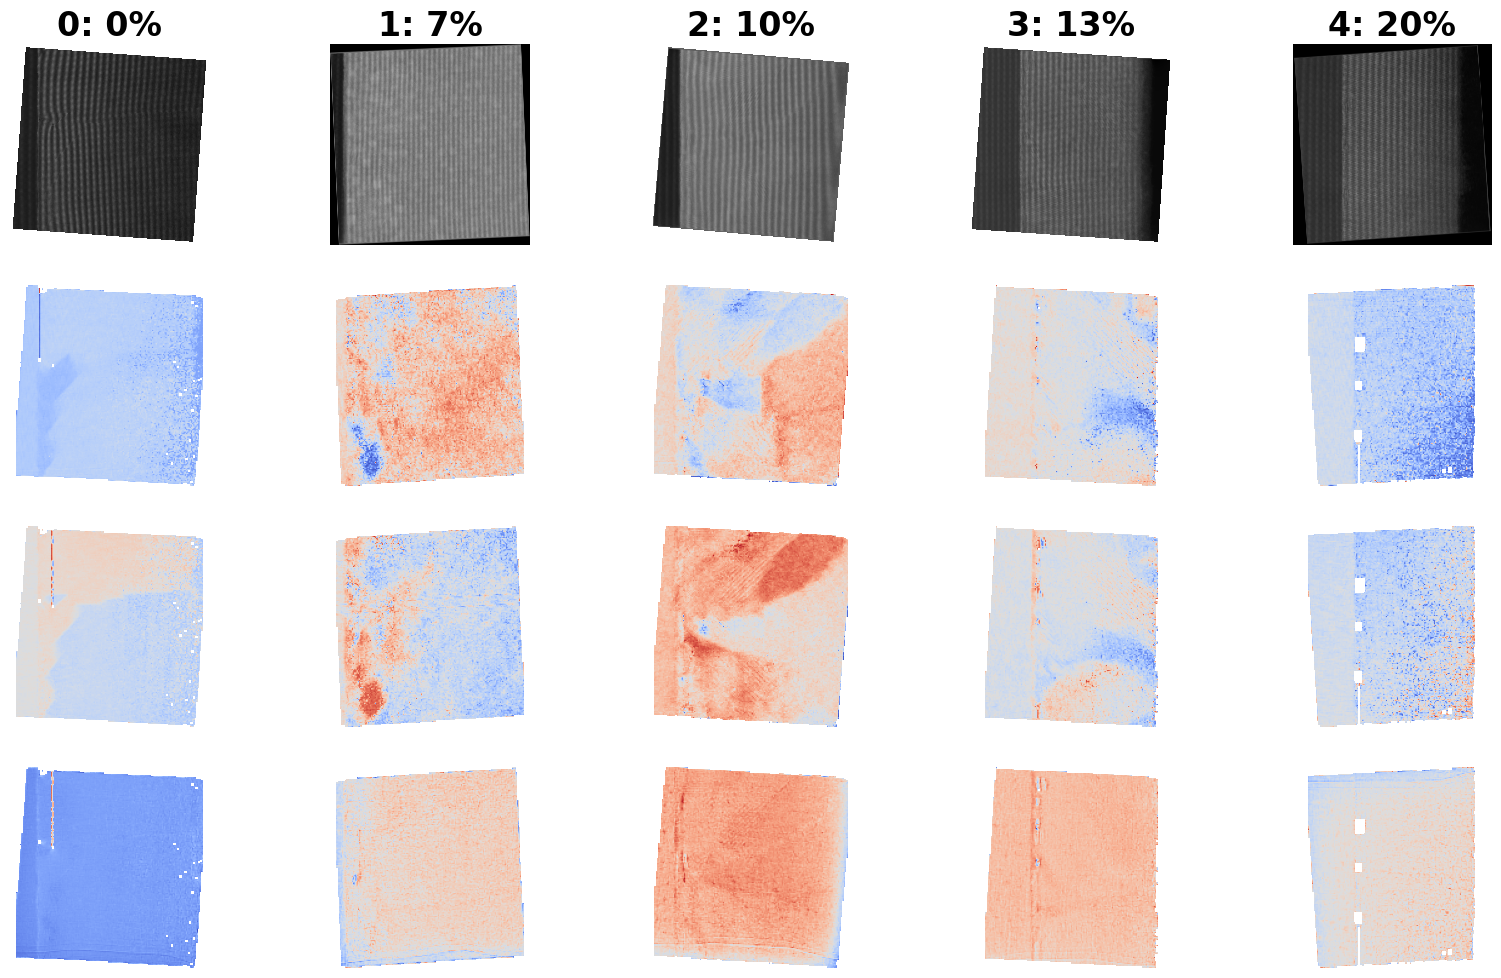

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=len(SBFOdata), figsize=(4*len(SBFOdata), 4*3), dpi=100)
for i, k in enumerate(SBFOdata):
  #Image
  ax[0,i].imshow(k['Image'], origin='upper', cmap='gray')
  ax[0,i].set_title(str(k['Index'])+': '+str(k['Composition'])+'%', fontsize = 24, fontweight = "bold")
  ax[0,i].set_axis_off()
  #Px
  ax[1,i].imshow(k['ab_Px'], origin='upper', cmap='coolwarm')
  ax[1,i].set_axis_off()
  #Py
  ax[2,i].imshow(k['ab_Py'], origin='upper', cmap='coolwarm')
  ax[2,i].set_axis_off()

  # Vol (added row to display Vol)
  ax[3, i].imshow(k['Vol'], origin='upper', cmap='coolwarm')
  ax[3, i].set_axis_off()

As you can see, for low Sm concentrations the olarization maps show clear ordered ferroelectric domains.On increasing Sm concentration, they become more disordered and then disappear for 20% Sm. Also note that unit cell volume map shows (some) variation between material and substrate, does not show variations associated with the domains, and also shows smooth changes across the image plane. The latter are associated with non-ideality of the microscope (the mis-tilt effects).

You can also note the missing regions on the last image. These correspond to the regions that contained growth defects and were removed during the curation of the data set.

## **Problem 2:** Unsupervised exploration

Now, let's explore one of the intermediate concentrations of Sm images using sliding window approach. Let's proceed as following:
- Import one of the images for the intermediate concentrations that show the presence of ferroelectric and ordered phases. Choose an image!
- Create a standard data sets, meaning coordinate array and matching array of patches. Here we add additional degree of freedom by allowing the window to be rectangular, (w1,w2).
- Let's  explore clustering given the patches, and explore window size effects

Custom function for chosing rectangular windows

In [15]:
# def custom_subimages(imgdata, step_size, window_size):
#     # Generate coordinates based on step size
#     height, width = imgdata.shape[:2]
#     x_coords = np.arange(0, height - window_size[0] + 1, step_size)
#     y_coords = np.arange(0, width - window_size[1] + 1, step_size)
#     coordinates = [(x, y) for x in x_coords for y in y_coords]

#     # Extract subimages of the specified window size
#     half_height = window_size[0] // 2
#     half_width = window_size[1] // 2
#     subimages_target = []
#     coms_target = []
#     removed_due_to_size = 0
#     removed_due_to_nans = 0
#     labels = []

#     for coord in coordinates:
#         cx, cy = coord
#         top = max(cx - half_height, 0)
#         bottom = min(cx + half_height, height)
#         left = max(cy - half_width, 0)
#         right = min(cy + half_width, width)

#         # row = str(top//window_size[1]) #MV added
#         # col = str(left//window_size[0]) #MV added
#         # label = 'R'+row+'C'+col #MV added
#         # labels.append(label)
#         #print(label) #MV added
#         #plt.savefig('chipped_images/' + label + '.jpg') #MV added

#         subimage = imgdata[top:bottom, left:right]

#         if subimage.shape != tuple(window_size):
#             removed_due_to_size += 1
#         elif np.isnan(subimage).any():
#             removed_due_to_nans += 1
#         else:
#             subimages_target.append(subimage)
#             coms_target.append(coord)


#     print("Number of subimages removed due to size mismatch:", removed_due_to_size)
#     print("Number of subimages removed due to NaNs:", removed_due_to_nans)

#     return np.array(subimages_target), np.array(coms_target)

Problem 2a:
- Select image and window size
- Cluster the image patches
- Visualize the labels map
- Estimate the required number of clusters


Problem 2b:
- Let's assume that we want to compare multiple clustering approaches. The problem is that cluster labels are assigned randomly, meaning (0,1,2) in one lcustering method will not match the labels from other method
- Suggest and realize approach to align the labels between different clustering methods

Problem 2c:
- Realize 3 different clustering methods of the data
- Align the labels
- Plot the average and uncertainty maps

In [16]:
import numpy as np
from PIL import Image
import os

def save_and_extract_subimages(imgdata, step_size, window_size, output_dir):
    """
    Extract subimages from an image and save them as JPEGs in the specified output directory.

    Parameters:
        imgdata (numpy.ndarray): The input image data (height, width, channels).
        step_size (int): The step size for generating subimages.
        window_size (tuple): The window size (height, width) of each subimage.
        output_dir (str): The directory where the subimages will be saved as JPEGs.

    Returns:
        subimages (numpy.ndarray): The list of extracted subimages.
        coordinates (list): The list of coordinates corresponding to each subimage.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get image dimensions
    height, width = imgdata.shape[:2]

    # Generate coordinates based on step size
    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    # Subimage extraction parameters
    half_height = window_size[0] // 2
    half_width = window_size[1] // 2

    # Lists to hold the valid subimages and their coordinates
    subimages_target = []
    coms_target = []
    removed_due_to_size = 0
    removed_due_to_nans = 0

    # Iterate over each coordinate and extract subimage
    for i, (cx, cy) in enumerate(coordinates):
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, height)
        left = max(cy - half_width, 0)
        right = min(cy + half_width, width)

        # Extract the subimage
        subimage = imgdata[top:bottom, left:right]

        # Check if the subimage matches the expected window size and contains no NaNs
        if subimage.shape != tuple(window_size):
            removed_due_to_size += 1
        elif np.isnan(subimage).any():
            removed_due_to_nans += 1
        else:
            # Add valid subimage and coordinates to the target list
            subimages_target.append(subimage)
            coms_target.append((cx, cy))

            # Ensure the data is in uint8 and clip values to be between 0 and 255
            subimage = np.clip(subimage, 0, 255).astype(np.uint8)

            # Convert to RGB if the subimage is not already in 3 channels
            if subimage.ndim == 2:  # Grayscale image
                subimage_rgb = np.stack([subimage] * 3, axis=-1)  # Convert to RGB by repeating the grayscale image
            elif subimage.shape[-1] != 3:  # In case there are more than 3 channels (e.g., RGBA)
                subimage_rgb = subimage[..., :3]  # Drop alpha channel if present
            else:
                subimage_rgb = subimage  # Already RGB

            # Convert to a PIL Image
            pil_image = Image.fromarray(subimage_rgb)

            # Generate the filename based only on the center of mass (cx, cy)
            filename = f"{cx}_{cy}.jpg"

            # Save the image as JPEG
            output_path = os.path.join(output_dir, filename)
            pil_image.save(output_path, "JPEG")
            # print(f"Saved subimage at center of mass (cx={cx}, cy={cy}) to {output_path}")

    print("Number of subimages removed due to size mismatch:", removed_due_to_size)
    print("Number of subimages removed due to NaNs:", removed_due_to_nans)

    return np.array(subimages_target), np.array(coms_target)

In [17]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/hack_the_microscope24

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/hack_the_microscope24


In [18]:
output_dir = "chipped_images/"

In [30]:
imgdata

[<HDF5 dataset "MainImage": shape (4454, 4405), type "<f8">,
 <HDF5 dataset "MainImage": shape (4268, 4245), type "<f8">,
 <HDF5 dataset "MainImage": shape (4520, 4527), type "<f8">,
 <HDF5 dataset "MainImage": shape (4375, 4443), type "<f8">,
 <HDF5 dataset "MainImage": shape (4397, 4348), type "<f8">]

In [19]:
window_size = (180,180)
step_size = 180

subimages, coordinates = save_and_extract_subimages(imgdata[0], step_size, window_size, output_dir)

Number of subimages removed due to size mismatch: 47
Number of subimages removed due to NaNs: 71


In [20]:
# window_size = (180,180)
# step_size = 180

# imstack_grid, com_grid, labels = custom_subimages(imgdata[0], step_size, window_size)

# print(imstack_grid.shape)
# print(com_grid.shape)
# print(len(labels))

In [21]:
# import numpy as np
# from PIL import Image
# import os

# def save_subimages_as_jpegs(subimage_array, output_dir):
#     """
#     Save each subimage in the 3D NumPy array as an RGB JPEG image in the specified output directory.

#     Parameters:
#         subimage_array (numpy.ndarray): A 3D NumPy array of shape (N, height, width), where N is the number of subimages.
#         output_dir (str): The directory where the subimages will be saved as JPEGs.
#     """
#     # Check if the output directory exists, if not, create it
#     os.makedirs(output_dir, exist_ok=True)

#     N, height, width = subimage_array.shape

#     for i in range(N):
#         # Extract the subimage
#         subimage = subimage_array[i]

#         # Ensure the data is in uint8 and clip values to be between 0 and 255
#         subimage = np.clip(subimage, 0, 255).astype(np.uint8)

#         # Convert to RGB if the subimage is not already in 3 channels
#         if subimage.ndim == 2:  # Grayscale image
#             subimage_rgb = np.stack([subimage] * 3, axis=-1)  # Convert to RGB by repeating the grayscale image
#         elif subimage.shape[-1] != 3:  # In case there are more than 3 channels (e.g., RGBA)
#             subimage_rgb = subimage[..., :3]  # Drop alpha channel if present
#         else:
#             subimage_rgb = subimage  # Already RGB

#         # Convert to a PIL Image
#         pil_image = Image.fromarray(subimage_rgb)

#         # Save the image as JPEG
#         output_path = os.path.join(output_dir, f"subimage_{i+1}.jpg")
#         pil_image.save(output_path, "JPEG")

# save_subimages_as_jpegs(imstack_grid, path)


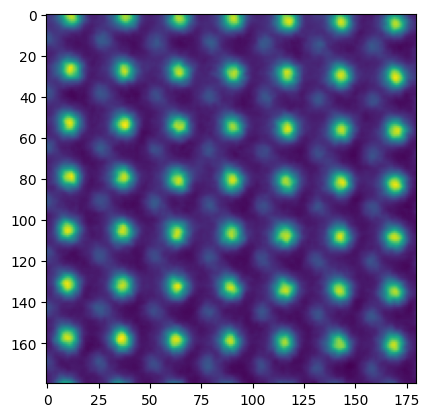

In [22]:
subimg = subimages[220]
subimgplot = plt.imshow(subimg)
plt.savefig('crop_images/img_180-180-180_220.png')

In [23]:
import os
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
from skimage import io


def img_embedding(image, preprocess_input, base_model, model_input_size=(32,32)):
    x = tf.image.resize(image, size=model_input_size)
    x = preprocess_input(x)
    x = base_model(np.expand_dims(x, axis=0))
    return x

def save_chip_database(database_path, df):
    # save chips as h5 database
    hf = h5py.File(database_path, 'a')
    cols = df.columns[1:]

    for i, row in df.iterrows():
        # create chip name
        name = row['chip ID']
        subgrp = hf.create_group(name)

        # save chip data
        for col in cols:
            _ = subgrp.create_dataset(col, data=row[col])

    hf.close()

def collect_data(chip_dir, database):
    # load chipped images
    x = glob.glob(os.path.join(chip_dir,'*.jpg'))
    chip_dict = {i.split('/')[-1].replace('.jpg',''):io.imread(i) for i in x}

    # create dataframe with data
    chip_df = pd.DataFrame()
    chip_df.index = chip_dict.keys()
    chip_df['chip ID'] = chip_dict.keys()
    chip_df = chip_df.reset_index(drop=True)
    # chip_df['com_grid'] = com_grid.tolist()
    chip_df['image data'] = chip_dict.values()
    chip_df['image data'] = chip_df['image data'].apply(lambda x: x.flatten())

    # extract image embeddings using pretrained VGG16
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications
    model_input_shape = (32,32,3)
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=model_input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    # add embeddings to dataframe
    chip_emb_dict={}
    for k,v in chip_dict.items():
         chip_emb_dict[k] = img_embedding(v, preprocess_input, base_model, model_input_shape[:2]).numpy().flatten()
    chip_df['image encoding data'] = chip_emb_dict.values()
    chip_df['image encoding data'] = chip_df['image encoding data'].apply(lambda x: x.flatten())
    print(chip_df.head())

    save_chip_database(database, chip_df)

In [24]:
chip_dir = 'chipped_images/'
database = 'data.h5'
collect_data(chip_dir, database)

    chip ID                                         image data  \
0   180_540  [43, 43, 43, 46, 46, 46, 50, 50, 50, 53, 53, 5...   
1  360_1440  [156, 156, 156, 127, 127, 127, 92, 92, 92, 71,...   
2  360_1260  [111, 111, 111, 91, 91, 91, 68, 68, 68, 55, 55...   
3  360_1080  [111, 111, 111, 96, 96, 96, 74, 74, 74, 57, 57...   
4   360_540  [66, 66, 66, 67, 67, 67, 66, 66, 66, 60, 60, 6...   

                                 image encoding data  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.880787, 32.5...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.916569, 35.0...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.941456, 35.8...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.331047, 32.3...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.055506, 31.6...  


In [25]:
%run louvain_community_detection.py --path_chip_db 'data.h5' --path_clustering_output "" --c 0.8

/gdrive/MyDrive/hack_the_microscope24/louvain_community_detection.py:28: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


Loading chip database from data.h5
Clustering individual modalities using cutoff=0.8
       chip ID                                         image data  \
0    1080_1080  [42, 42, 42, 43, 43, 43, 45, 45, 45, 47, 47, 4...   
1    1080_1260  [34, 34, 34, 37, 37, 37, 40, 40, 40, 44, 44, 4...   
2    1080_1440  [34, 34, 34, 46, 46, 46, 62, 62, 62, 77, 77, 7...   
3    1080_1620  [36, 36, 36, 40, 40, 40, 50, 50, 50, 65, 65, 6...   
4    1080_1800  [32, 32, 32, 33, 33, 33, 36, 36, 36, 44, 44, 4...   
..         ...                                                ...   
453   900_3960  [18, 18, 18, 19, 19, 19, 20, 20, 20, 19, 19, 1...   
454   900_4140  [19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 1...   
455    900_540  [75, 75, 75, 84, 84, 84, 90, 90, 90, 87, 87, 8...   
456    900_720  [151, 151, 151, 150, 150, 150, 146, 146, 146, ...   
457    900_900  [75, 75, 75, 80, 80, 80, 83, 83, 83, 84, 84, 8...   

                                   image encoding data  
0    [0.0, 0.0, 0.0, 0.0, 0.0

ValueError: columns overlap but no suffix specified: Index(['chip ID'], dtype='object')

<Figure size 640x480 with 0 Axes>

In [26]:
%run plot_results.py --path_chip_db "data.h5" --path_clustering_output "./results.csv"

Loading clustering results
...chip database: data.h5
...clustering output: ./results.csv
Index(['chip ID', 'image data', 'image encoding data'], dtype='object')


KeyError: 'com_grid'

In [27]:
temp = pd.read_csv('results.csv')
temp.head()

,chip ID,image data,image encoding data
0,1080_1080,[42 42 42 ... 40 40 40],[ 0. 0. 0. 0. ...
1,1080_1260,[34 34 34 ... 31 31 31],[ 0. 0. 0. 0. ...
2,1080_1440,[34 34 34 ... 33 33 33],[ 0. 0. 0. 0. ...
3,1080_1620,[36 36 36 ... 36 36 36],[ 0. 0. 0. 0. ...
4,1080_1800,[32 32 32 ... 48 48 48],[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0...


In [28]:
from skimage import io

chip_dir = 'chipped_images/'
com_grid = coordinates

# load chipped images
x = glob.glob(os.path.join(chip_dir,'*.jpg'))
chip_dict = {i.split('/')[-1].replace('.jpg',''):io.imread(i) for i in x}

# create dataframe with data
chip_df = pd.DataFrame()
chip_df.index = chip_dict.keys()
chip_df['chip ID'] = chip_dict.keys()
chip_df['com_grid'] = com_grid.tolist()
chip_df['image data'] = chip_dict.values()
chip_df['image data'] = chip_df['image data'].apply(lambda x: x.flatten())

# extract image embeddings using pretrained VGG16
# https://www.tensorflow.org/api_docs/python/tf/keras/applications
model_input_shape = (32,32,3)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
base_model = tf.keras.applications.vgg16.VGG16(input_shape=model_input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# add embeddings to dataframe
chip_emb_dict={}
for k,v in chip_dict.items():
      chip_emb_dict[k] = img_embedding(v, preprocess_input, base_model, model_input_shape[:2]).numpy().flatten()
chip_df['image encoding data'] = chip_emb_dict.values()
chip_df['image encoding data'] = chip_df['image encoding data'].apply(lambda x: x.flatten())

# print('saving...')
# save_chip_database(database, chip_df)

In [29]:
chip_df.head()

,chip ID,com_grid,image data,image encoding data
180_540,180_540,"[180, 540]","[43, 43, 43, 46, 46, 46, 50, 50, 50, 53, 53, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.880787, 32.5..."
360_1440,360_1440,"[180, 720]","[156, 156, 156, 127, 127, 127, 92, 92, 92, 71,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.916569, 35.0..."
360_1260,360_1260,"[360, 540]","[111, 111, 111, 91, 91, 91, 68, 68, 68, 55, 55...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.941456, 35.8..."
360_1080,360_1080,"[360, 720]","[111, 111, 111, 96, 96, 96, 74, 74, 74, 57, 57...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.331047, 32.3..."
360_540,360_540,"[360, 900]","[66, 66, 66, 67, 67, 67, 66, 66, 66, 60, 60, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.055506, 31.6..."
